# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [1]:
!pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [2]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

import pickle
from genepro.selection import tournament_selection
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [3]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [5]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [6]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards_list = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    rewards = []
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here?
      action =  torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break
    rewards_list.append(rewards)

  fitness = np.sum([np.sum(rewards) for rewards in rewards_list])
  
  return fitness, memory

## Selection function
Here we use a boolean to check how the variation of the population is. If at some point it is above a threshold, we switch our seleciton function. We first use Roulette Wheel selection, then switch to tournament selection. This is a simple way to ensure diversity in the population.

In [17]:
def roulette_wheel_selection(population, number_to_select, num_gens): 
    min_fitness = min(ind.fitness for ind in population)
    if min_fitness < 0:
        # Normalize fitness values to be non-negative
        normalized_fitnesses = [ind.fitness - min_fitness for ind in population]
    else:
        # If all fitness values are non-negative, use them directly
        normalized_fitnesses = [ind.fitness for ind in population]
    total_fitness = sum(normalized_fitnesses)
    selection_probs = [f / total_fitness for f in normalized_fitnesses]
    selected = []
    for i in range(number_to_select):
        selected_index = np.random.choice(len(population), p=selection_probs)
        selected.append(population[selected_index])
    return selected

In [8]:
def combined_selection_difference_from_mean(population, number_to_select, num_gens, tournament_size):
    # max difference action is leading
    min_fitness = population[0].fitness
    max_fitness = population[0].fitness
    sum_fitness = 0
    for i in range(len(population)):
        current_fitness = population[i].fitness
        if current_fitness < min_fitness:
            min_fitness = current_fitness
        if current_fitness > max_fitness:
            max_fitness = current_fitness
        sum_fitness += current_fitness

    average_fitness = sum_fitness / len(population)
    if abs(max_fitness - average_fitness) < abs(min_fitness - average_fitness):
        has_deviated = True
    else:
        has_deviated = False
    if has_deviated:
        # Use tournament selection
        print("Using tournament selection")
        return tournament_selection(population, number_to_select, num_gens, tournament_size=tournament_size)
    else:
        # Use roulette wheel selection
        print("Using roulette wheel selection")
        return roulette_wheel_selection(population, number_to_select, num_gens)

In [9]:
def combined_selection_hard_criteria(population, number_to_select, num_gens, tournament_size, switch_criteria):
    if num_gens > switch_criteria:
        # Use tournament selection
        print("Using tournament selection")
        return tournament_selection(population, number_to_select, num_gens, tournament_size=tournament_size)
    else:
        # Use roulette wheel selection
        print("Using roulette wheel selection")
        return roulette_wheel_selection(population, number_to_select, num_gens)

In [10]:
def combined_selection_hard_criteria_reverse(population, number_to_select, num_gens, tournament_size, switch_criteria):
    if num_gens < switch_criteria:
        # Use tournament selection
        print("Using tournament selection")
        return tournament_selection(population, number_to_select, num_gens, tournament_size=tournament_size)
    else:
        # Use roulette wheel selection
        print("Using roulette wheel selection")
        return roulette_wheel_selection(population, number_to_select, num_gens)

In [11]:
def combined_selection_std(population, number_to_select, num_gens, tournament_size):
    # max difference action is leading
    fitnesses = [ind.fitness for ind in population]
    normalized_fitnesses = np.array(fitnesses) / np.mean(fitnesses) if np.mean(fitnesses) != 0 else np.array(fitnesses)
    normalized_std_fitness = np.std(normalized_fitnesses)
    print(f"Normalized standard deviation of fitnesses: {normalized_std_fitness}")
    if normalized_std_fitness > 0.6:
        # Use tournament selection
        print("Using tournament selection")
        return tournament_selection(population, number_to_select, num_gens, tournament_size=tournament_size)
    else:
        # Use roulette wheel selection
        print("Using roulette wheel selection")
        return roulette_wheel_selection(population, number_to_select, num_gens)

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here.

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [12]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant() for _ in range(num_features)] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here
selection_function = {
    "fun":combined_selection_hard_criteria,
    "kwargs":{"tournament_size": 16, 
              "switch_criteria": -1} # Switch to tournament selection after 10 generations
              }
evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=64,
  max_gens=30,
  max_tree_size=30,
  selection=selection_function,
  n_jobs=8,
  verbose=True)

## Evolve
Running this cell will use all the settings above as parameters

In [13]:
evo.evolve()

Using tournament selection


KeyboardInterrupt: 

In [ ]:
# Save evo.best_of_gens to file
if not os.path.exists("experiments"):
    os.makedirs("experiments")
    
experiment_name = f"evo_n={evo.pop_size}_ng={evo.max_gens}_t={evo.max_tree_size}_s={selection_function['fun'].__name__}.pt"
experiment_path = os.path.join("experiments", experiment_name)
with open(experiment_path.replace(".pt", ".pkl"), "wb") as f:
    pickle.dump(evo, f)

### Selection method experiment setup

In [ ]:
selection_functions = [roulette_wheel_selection, 
                      tournament_selection]
switch_criteria = [7, 14, 22]
selection_hard_criteria = [{"fun": combined_selection_hard_criteria,
                          "kwargs": {"tournament_size": 16, "switch_criteria": i}} for i in switch_criteria]
selection_hard_criteria_reverse = [{"fun": combined_selection_hard_criteria_reverse,
                          "kwargs": {"tournament_size": 16, "switch_criteria": i}} for i in switch_criteria]
# selection_functions_arg = [{"fun": func, "kwargs":{"tournament_size": 16}} for func in selection_functions]
selection_hard_criteria.extend(selection_hard_criteria_reverse)

n_runs = 3
pop_size = 128
max_gens = 30

for selection_function in selection_hard_criteria:
    for i in range(n_runs):
      print(f"Running evolution with selection function: {selection_function['fun'].__name__}, run {i+1}/{n_runs}")
      evo = Evolution(
        fitness_function_pt, internal_nodes, leaf_nodes,
        4,
        pop_size=pop_size,
        max_gens=max_gens,
        max_tree_size=30,
        selection=selection_function,
        n_jobs=8,
        verbose=True)

      evo.evolve()

      if selection_function["fun"] == combined_selection_hard_criteria or selection_function["fun"] == combined_selection_hard_criteria_reverse:
          selection_name = f"{selection_function['fun'].__name__}_sc={selection_function['kwargs']['switch_criteria']}"
      else:
          selection_name = selection_function["fun"].__name__

      experiment_name = f"{selection_name}_n={evo.pop_size}_ng={evo.max_gens}_t={evo.max_tree_size}_{i}.pkl"
      experiment_path = os.path.join("experiments", experiment_name)
      
      if not os.path.exists("experiments"):
        os.makedirs("experiments")

      # save as pickle
      with open(experiment_path, "wb") as f:
          pickle.dump(evo, f)
    winsound.Beep(frequency, duration)

Running evolution with selection function: combined_selection_hard_criteria, run 1/3
Using roulette wheel selection
gen: 1,	best of gen fitness: -406.680,	best of gen size: 25
Using roulette wheel selection
gen: 2,	best of gen fitness: -406.680,	best of gen size: 25
Using roulette wheel selection
gen: 3,	best of gen fitness: -406.680,	best of gen size: 25
Using roulette wheel selection
gen: 4,	best of gen fitness: -406.680,	best of gen size: 25
Using roulette wheel selection
gen: 5,	best of gen fitness: -267.906,	best of gen size: 27
Using roulette wheel selection
gen: 6,	best of gen fitness: -267.906,	best of gen size: 27
Using roulette wheel selection
gen: 7,	best of gen fitness: -267.906,	best of gen size: 27
Using roulette wheel selection
gen: 8,	best of gen fitness: -267.906,	best of gen size: 27
Using roulette wheel selection
gen: 9,	best of gen fitness: -267.906,	best of gen size: 27
Using roulette wheel selection
gen: 10,	best of gen fitness: -267.906,	best of gen size: 27
Usin

# Test

In [19]:
def get_test_score(tree):
    rewards_list = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]
      rewards = []

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)# What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break
      rewards_list.append(rewards)

    fitness = np.sum([np.sum(r) for r in rewards_list])
    
    return fitness

# best = evo.best_of_gens[-1]

# print(best.get_readable_repr())
# print(get_test_score(best))

In [20]:
# Get test score for each experiment
def get_test_scores_from_experiment(experiment_path):
    with open(experiment_path, "rb") as f:
        evo = pickle.load(f)
    return [get_test_score(best) for best in evo.best_of_gens]

switch_criteria = [7, 14, 22]
selection_hard_criteria = [{"fun": combined_selection_hard_criteria,
                          "kwargs": {"tournament_size": 16, "switch_criteria": i}} for i in switch_criteria]
selection_hard_criteria_reverse = [{"fun": combined_selection_hard_criteria_reverse,
                          "kwargs": {"tournament_size": 16, "switch_criteria": i}} for i in switch_criteria]
# selection_functions_arg = [{"fun": func, "kwargs":{"tournament_size": 16}} for func in selection_functions]
selection_hard_criteria.extend(selection_hard_criteria_reverse)

test_scores = {}
for selection_function in selection_hard_criteria:
    print(f"Running test scores for selection function: {selection_function['fun'].__name__}")
    if selection_function["fun"] == combined_selection_hard_criteria or selection_function["fun"] == combined_selection_hard_criteria_reverse:
        selection_name = f"{selection_function['fun'].__name__}_sc={selection_function['kwargs']['switch_criteria']}"
    else:
        selection_name = selection_function["fun"].__name__

    test_scores[selection_name] = []
    for i in range(n_runs):
        experiment_name = f"{selection_name}_n={pop_size}_ng={max_gens}_t=30_{i}.pkl"
        experiment_path = os.path.join("experiments/selection", experiment_name)
        test_scores[selection_name].append(get_test_scores_from_experiment(experiment_path))

Running test scores for selection function: combined_selection_hard_criteria


c:\Users\shirl\Documents\Studie\2024-2025\Evolutionary Algorithms\Assignment 2\ea-lunarlander\.venv\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running test scores for selection function: combined_selection_hard_criteria
Running test scores for selection function: combined_selection_hard_criteria
Running test scores for selection function: combined_selection_hard_criteria_reverse
Running test scores for selection function: combined_selection_hard_criteria_reverse
Running test scores for selection function: combined_selection_hard_criteria_reverse


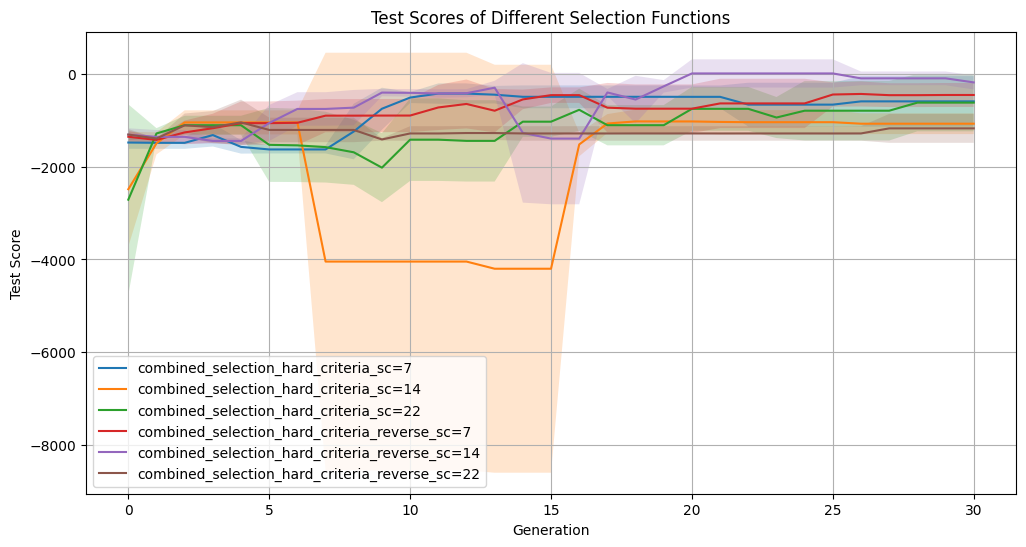

In [44]:
# Plot mean and std of test scores
def plot_test_scores(test_scores):
    plt.figure(figsize=(12, 6))
    for selection_name, scores in test_scores.items():
        mean_scores = np.mean(scores, axis=0)
        std_scores = np.std(scores, axis=0)
        plt.plot(mean_scores, label=selection_name)
        plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)

    plt.title("Test Scores of Different Selection Functions")
    plt.xlabel("Generation")
    plt.ylabel("Test Score")
    plt.legend()
    plt.grid()
    plt.show()
plot_test_scores(test_scores)

In [45]:
# Check if there is statistical significance between the test scores of the different selection functions
from scipy.stats import ttest_ind, ranksums
def check_statistical_significance(test_scores):
    selection_names = list(test_scores.keys())
    for i in range(len(selection_names)):
        for j in range(i + 1, len(selection_names)):
            name1 = selection_names[i]
            name2 = selection_names[j]
            scores1 = test_scores[name1]
            scores2 = test_scores[name2]
            t_stat, p_value = ranksums(scores1, scores2)
            if any(p_value) < 0.05:
                print(f"Statistically significant difference between {name1} and {name2}: p-value={p_value}")
check_statistical_significance(test_scores)

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [54]:
path_of_best = "experiments\selection\combined_selection_hard_criteria_reverse_sc=14_n=128_ng=30_t=30_2.pkl"
with open(path_of_best, "rb") as f:
    best = pickle.load(f).best_of_gens[-1]

MovieWriter imagemagick unavailable; using Pillow instead.


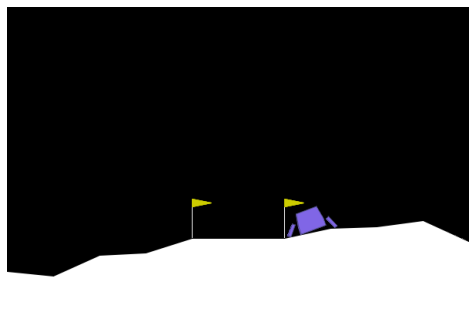

In [55]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [56]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

['(((2.638417274867613+x_4)-(x_0+(x_6*x_2)))/(((((x_0+-2.1689110986649305)/x_4)*((x_6*-1.1511690995128598)+(x_1+x_7)))/x_4)*(x_1+x_7)))', '((((4.760003501448691*0.196918948512311)/(0.9788146615028381*-1.837035059928894))/(x_4-x_6))-((x_6-(3.1960190332578446/-4.326924503220314))*(((x_3--2.603525262289757)-3.2811107459311373)*(-3.7886782001920474+x_2))))', '((((x_5*(x_5-x_0))-(1.4129021167755127*(x_5+x_3)))+(0.12336818015981668-((1.4129021167755127*(x_5+x_3))+x_2)))+-0.05428001160712031)', '(((-3.6477756404895842*x_1)-x_2)/(((x_6/x_3)-2.325101814456858)+(x_4/x_3)))']
-1665.8245840869972


MovieWriter imagemagick unavailable; using Pillow instead.


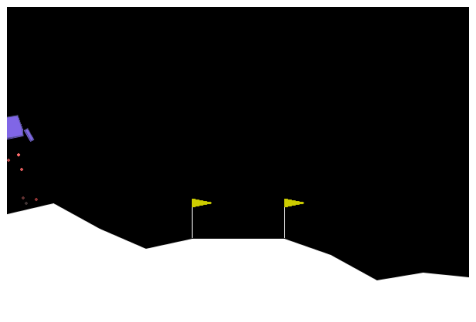

In [57]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">